- [Github](https://github.com/karpathy/micrograd)
- [Video](https://www.youtube.com/watch?v=VMj-3S1tku0)

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def f(x):
    return 3 * x**2 - 4 * x + 5

In [3]:
f(3.0)

20.0

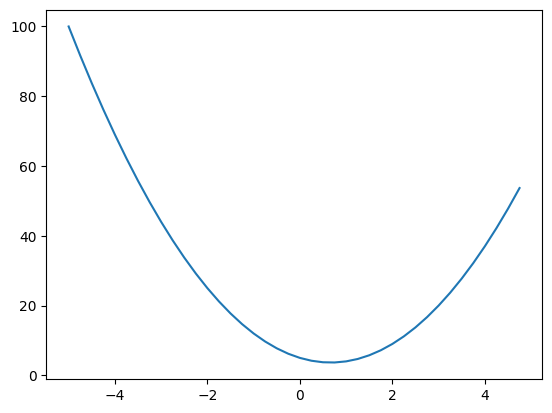

In [4]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [5]:
h = 0.001
x = 3.0
(f(x + h) - f(x))/h

14.00300000000243

In [6]:
a = 2.0
b = -3.0
c = 10.0


d1 = a * b + c
h = 0.0001
a += h
d2 = a * b + c

print((d2 - d1) / h)

-3.000000000010772


In [7]:
class Value:

    def __init__(self, data) -> None:
        self.data = data

    def __repr__(self) -> str:
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        return Value(self.data + other.data)
    
    def __mul__(self, other):
        return Value(self.data * other.data)

a = Value(2.0)
b = Value(-3.0)
c = Value(10.0)

print(a)
print(b)

Value(data=2.0)
Value(data=-3.0)


In [8]:
a * b

Value(data=-6.0)

In [9]:
a * b + c

Value(data=4.0)

In [10]:
class Value:

    def __init__(self, data, children=(), op='', label='') -> None:
        self.data = data
        self._prev = set(children)
        self._op = op
        self._label = label
        self._grad = 0.0

    def __repr__(self) -> str:
        return f"Value(data={self.data}, _prev={self._prev}, _op={self._op}, label={self._label})"
    
    def __add__(self, other):
        return Value(self.data + other.data, (self, other), '+')
    
    def __mul__(self, other):
        return Value(self.data * other.data, (self, other), '*')

a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')

print(a)
print(b)

Value(data=2.0, _prev=set(), _op=, label=a)
Value(data=-3.0, _prev=set(), _op=, label=b)


In [11]:
print(a * b + c)

Value(data=4.0, _prev={Value(data=10.0, _prev=set(), _op=, label=c), Value(data=-6.0, _prev={Value(data=-3.0, _prev=set(), _op=, label=b), Value(data=2.0, _prev=set(), _op=, label=a)}, _op=*, label=)}, _op=+, label=)


In [12]:
from graphviz import Digraph

def build_tree(root_node):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root_node)
    return nodes, edges

def gen_id(node):
    return str(id(node))

def draw_graph(root_node):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})
    nodes, edges = build_tree(root_node)
    
    for n in nodes:
        uid = gen_id(n)
        dot.node(name=uid, label="{ %s | data: %.4f} | grad: %.4f" % (n._label, n.data, n._grad), shape='record')
        if n._op:
            dot.node(name=uid + n._op, label=n._op)
            dot.edge(uid + n._op, uid)
    for n1, n2 in edges:
        dot.edge(gen_id(n1), gen_id(n2) + n2._op)

    return dot

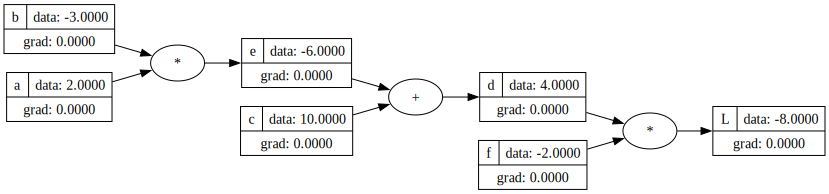

In [13]:
e = a * b
e._label = 'e'
d = e + c
d._label = 'd'
f = Value(-2.0, label='f')
L = f * d
L._label = 'L'

draw_graph(L)

In [14]:
def Tanh(v: Value) -> Value:
    x_2 = 2 * v.data
    t = (math.exp(x_2) - 1)/(math.exp(x_2) + 1)
    return Value(t, (v, ), 'tanh')


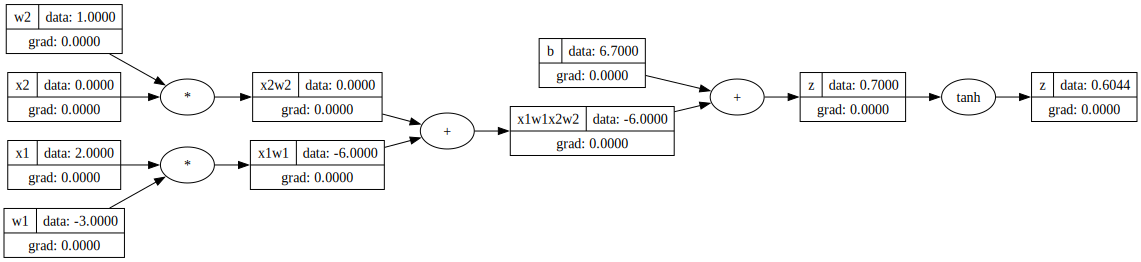

In [15]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

b = Value(6.7, label='b')

x1w1 = x1 * w1; x1w1._label = 'x1w1'
x2w2 = x2 * w2; x2w2._label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2._label = 'x1w1x2w2'
z = x1w1x2w2 + b; z._label = 'z'
o = Tanh(z); o._label = 'z'

draw_graph(o)

# Gradient Backprop

In [41]:
class Value:

    def __init__(self, data, children=(), op='', label='') -> None:
        self.data = data
        self._prev = set(children)
        self._op = op
        self._label = label
        self._grad = 0.0
        self._backward = lambda: None

    def __repr__(self) -> str:
        return f"Value(data={self.data}, _prev={self._prev}, _op={self._op}, label={self._label})"
    
    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')
    
        def _backward():
            self._grad = 1.0 * out._grad
            other._grad = 1.0 * out._grad

        out._backward = _backward

        return out
    
    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self._grad = other.data * out._grad
            other._grad = self.data * out._grad

        out._backward = _backward

        return out

def Tanh(v: Value) -> Value:
    x_2 = 2 * v.data
    t = (math.exp(x_2) - 1)/(math.exp(x_2) + 1)
    out = Value(t, (v, ), 'tanh')
    
    def _backward():
        v._grad = (1 - t**2) * out._grad
    
    out._backward = _backward

    return out


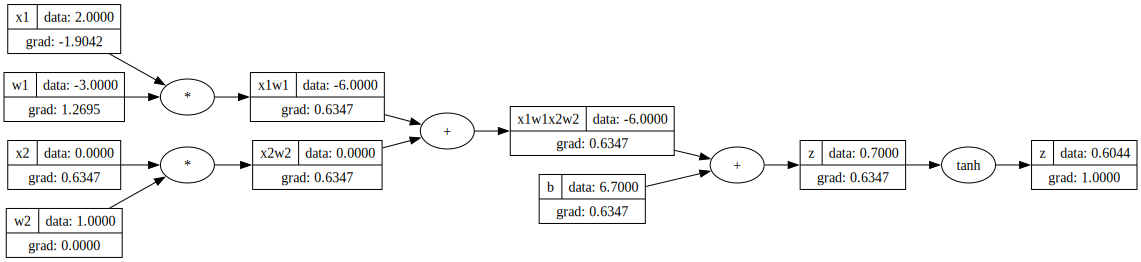

In [42]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

b = Value(6.7, label='b')

x1w1 = x1 * w1; x1w1._label = 'x1w1'
x2w2 = x2 * w2; x2w2._label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2._label = 'x1w1x2w2'
z = x1w1x2w2 + b; z._label = 'z'
o = Tanh(z); o._label = 'z'

o._grad = 1
o._backward()
z._backward()
x1w1x2w2._backward()
b._backward()
x1w1._backward()
x2w2._backward()
x1._backward()
x2._backward()

draw_graph(o)

# Backprop chain

In [43]:
order_chain = []
visited = set()
def build_chain(v: Value):
    if v not in visited:
        visited.add(v)
        for ch in v._prev:
            build_chain(ch)
        order_chain.append(v)

build_chain(o)
order_chain

[Value(data=0.0, _prev=set(), _op=, label=x2),
 Value(data=1.0, _prev=set(), _op=, label=w2),
 Value(data=0.0, _prev={Value(data=0.0, _prev=set(), _op=, label=x2), Value(data=1.0, _prev=set(), _op=, label=w2)}, _op=*, label=x2w2),
 Value(data=2.0, _prev=set(), _op=, label=x1),
 Value(data=-3.0, _prev=set(), _op=, label=w1),
 Value(data=-6.0, _prev={Value(data=2.0, _prev=set(), _op=, label=x1), Value(data=-3.0, _prev=set(), _op=, label=w1)}, _op=*, label=x1w1),
 Value(data=-6.0, _prev={Value(data=0.0, _prev={Value(data=0.0, _prev=set(), _op=, label=x2), Value(data=1.0, _prev=set(), _op=, label=w2)}, _op=*, label=x2w2), Value(data=-6.0, _prev={Value(data=2.0, _prev=set(), _op=, label=x1), Value(data=-3.0, _prev=set(), _op=, label=w1)}, _op=*, label=x1w1)}, _op=+, label=x1w1x2w2),
 Value(data=6.7, _prev=set(), _op=, label=b),
 Value(data=0.7000000000000002, _prev={Value(data=-6.0, _prev={Value(data=0.0, _prev={Value(data=0.0, _prev=set(), _op=, label=x2), Value(data=1.0, _prev=set(), _op=

In [44]:
class Value:

    def __init__(self, data, children=(), op='', label='') -> None:
        self.data = data
        self._prev = set(children)
        self._op = op
        self._label = label
        self._grad = 0.0
        self._backward = lambda: None

    def __repr__(self) -> str:
        return f"Value(data={self.data}, _op={self._op}, label={self._label})"
    
    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')
    
        def _backward():
            self._grad = 1.0 * out._grad
            other._grad = 1.0 * out._grad

        out._backward = _backward

        return out
    
    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self._grad = other.data * out._grad
            other._grad = self.data * out._grad

        out._backward = _backward

        return out

    def backward(self):
        order_chain = []
        visited = set()

        def _build_chain(v: Value):
            if v not in visited:
                visited.add(v)
                for ch in v._prev:
                    _build_chain(ch)
                order_chain.append(v)

        _build_chain(self)
        self._grad = 1.0
        for n in reversed(order_chain):
            n._backward()
            print(n, "_backward")


Value(data=0.6043677771171636, _op=tanh, label=o) _backward
Value(data=0.7000000000000002, _op=+, label=z) _backward
Value(data=-6.0, _op=+, label=x1w1x2w2) _backward
Value(data=0.0, _op=*, label=x2w2) _backward
Value(data=0.0, _op=, label=x2) _backward
Value(data=1.0, _op=, label=w2) _backward
Value(data=-6.0, _op=*, label=x1w1) _backward
Value(data=-3.0, _op=, label=w1) _backward
Value(data=2.0, _op=, label=x1) _backward
Value(data=6.7, _op=, label=b) _backward


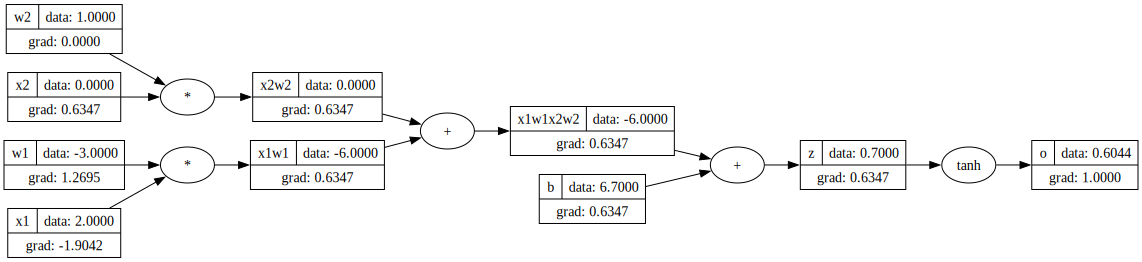

In [45]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

b = Value(6.7, label='b')

x1w1 = x1 * w1; x1w1._label = 'x1w1'
x2w2 = x2 * w2; x2w2._label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2._label = 'x1w1x2w2'
z = x1w1x2w2 + b; z._label = 'z'
o = Tanh(z); o._label = 'o'

o._grad = 1
o.backward()

draw_graph(o)

# Make the operations more complete

Value(data=6.0, _op=+, label=b) _backward
Value(data=3.0, _op=, label=a) _backward


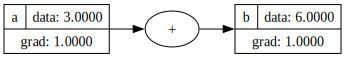

In [46]:
a = Value(3.0, label='a')
b = a + a; b._label = 'b'
b.backward()

draw_graph(b)

Value(data=-6.0, _op=*, label=f) _backward
Value(data=1.0, _op=+, label=e) _backward
Value(data=-6.0, _op=*, label=d) _backward
Value(data=-2.0, _op=, label=a) _backward
Value(data=3.0, _op=, label=b) _backward


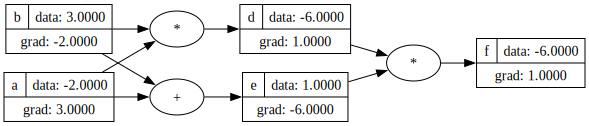

In [47]:
a = Value(-2.0, label='a')
b = Value(3.0, label='b')

d = a * b; d._label = 'd'
e = a + b; e._label = 'e'
f = d * e; f._label = 'f'
f.backward()

draw_graph(f)

In [48]:
class Value:

    def __init__(self, data, children=(), op='', label='') -> None:
        self.data = data
        self._prev = set(children)
        self._op = op
        self._label = label
        self._grad = 0.0
        self._backward = lambda: None

    def __repr__(self) -> str:
        return f"Value(data={self.data}, _op={self._op}, label={self._label})"
    
    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')
    
        def _backward():
            self._grad += 1.0 * out._grad
            other._grad += 1.0 * out._grad

        out._backward = _backward

        return out
    
    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self._grad += other.data * out._grad
            other._grad += self.data * out._grad

        out._backward = _backward

        return out

    def backward(self):
        order_chain = []
        visited = set()

        def _build_chain(v: Value):
            if v not in visited:
                visited.add(v)
                for ch in v._prev:
                    _build_chain(ch)
                order_chain.append(v)

        _build_chain(self)
        self._grad = 1.0
        for n in reversed(order_chain):
            n._backward()
            print(n, "_backward")


Value(data=6.0, _op=+, label=b) _backward
Value(data=3.0, _op=, label=a) _backward


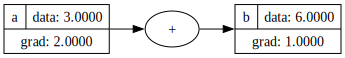

In [49]:
a = Value(3.0, label='a')
b = a + a; b._label = 'b'
b.backward()

draw_graph(b)

Value(data=-6.0, _op=*, label=f) _backward
Value(data=-6.0, _op=*, label=d) _backward
Value(data=1.0, _op=+, label=e) _backward
Value(data=-2.0, _op=, label=a) _backward
Value(data=3.0, _op=, label=b) _backward


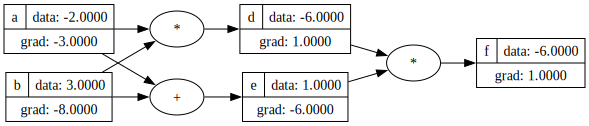

In [50]:
a = Value(-2.0, label='a')
b = Value(3.0, label='b')

d = a * b; d._label = 'd'
e = a + b; e._label = 'e'
f = d * e; f._label = 'f'
f.backward()

draw_graph(f)

In [183]:
class Value:

    def __init__(self, data, children=(), op='', label='') -> None:
        self.data = data
        self._prev = set(children)
        self._op = op
        self._label = label
        self._grad = 0.0
        self._backward = lambda: None

    def __repr__(self) -> str:
        return f"Value(data={self.data}, _op={self._op}, label={self._label})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(data=other)
        out = Value(self.data + other.data, (self, other), '+')
    
        def _backward():
            self._grad += 1.0 * out._grad
            other._grad += 1.0 * out._grad

        out._backward = _backward

        return out
    
    def __radd__(self, other):
        return self + other
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(data=other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self._grad += other.data * out._grad
            other._grad += self.data * out._grad

        out._backward = _backward

        return out
    
    def __rmul__(self, other):
        return self * other
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self._grad += out._grad * out.data

        out._backward = _backward
        return out

    def __pow__(self, k):
        assert isinstance(k, (int, float)), "only support int/float for power"
        out = Value(self.data**k, (self, ), f"**{k}")

        def _backward():
            self._grad += k * (self.data**(k-1)) * out._grad
        
        out._backward = _backward
        return out

    def __truediv__(self, other):
        other = other if isinstance(other, Value) else Value(data=other)
        return self * (other ** -1)

    def __neg__(self):
        return self * -1
    
    def __sub__(self, other):
        other = other if isinstance(other, Value) else Value(data=other)
        return self + (- other)

    def backward(self):
        order_chain = []
        visited = set()

        def _build_chain(v: Value):
            if v not in visited:
                visited.add(v)
                for ch in v._prev:
                    _build_chain(ch)
                order_chain.append(v)

        _build_chain(self)
        self._grad = 1.0
        for n in reversed(order_chain):
            n._backward()
            # print(n, "_backward")


In [74]:
a = Value(2.0, label='a')
print(a + 1)
print(1 + a)
print(a * 2)
print(2 * a)
print(a**3)
print(a.exp())
print(a ** -1)
print(a / 3)
print(a - 3)

Value(data=3.0, _op=+, label=)
Value(data=3.0, _op=+, label=)
Value(data=4.0, _op=*, label=)
Value(data=4.0, _op=*, label=)
Value(data=8.0, _op=**3, label=)
Value(data=7.38905609893065, _op=exp, label=)
Value(data=0.5, _op=**-1, label=)
Value(data=0.6666666666666666, _op=*, label=)
Value(data=-1.0, _op=+, label=)


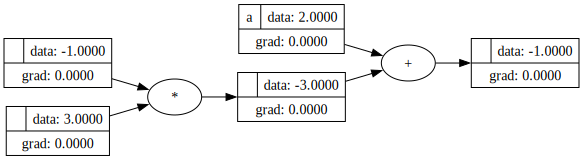

In [75]:
draw_graph(a - 3)

Value(data=0.6043677771171636, _op=tanh, label=) _backward
Value(data=0.7000000000000002, _op=+, label=z) _backward
Value(data=6.7, _op=, label=b) _backward
Value(data=-6.0, _op=+, label=x1w1x2w2) _backward
Value(data=-6.0, _op=*, label=x1w1) _backward
Value(data=-3.0, _op=, label=w1) _backward
Value(data=2.0, _op=, label=x1) _backward
Value(data=0.0, _op=*, label=x2w2) _backward
Value(data=0.0, _op=, label=x2) _backward
Value(data=1.0, _op=, label=w2) _backward


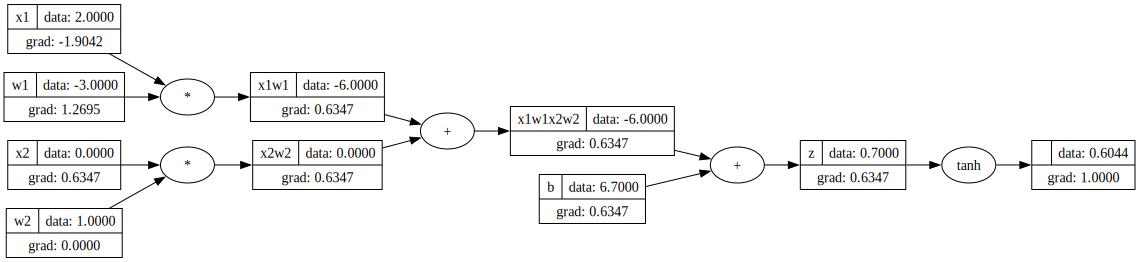

In [78]:
def Tanh(v: Value) -> Value:
    x_2 = 2 * v.data
    t = (math.exp(x_2) - 1)/(math.exp(x_2) + 1)
    out = Value(t, (v, ), 'tanh')
    
    def _backward():
        v._grad += (1 - t**2) * out._grad
    
    out._backward = _backward

    return out

x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

b = Value(6.7, label='b')

x1w1 = x1 * w1; x1w1._label = 'x1w1'
x2w2 = x2 * w2; x2w2._label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2._label = 'x1w1x2w2'
z = x1w1x2w2 + b; z._label = 'z'

o = Tanh(z)

o.backward()

draw_graph(o)

Value(data=0.6043677771171637, _op=*, label=) _backward
Value(data=0.1978161114414182, _op=**-1, label=) _backward
Value(data=5.055199966844676, _op=+, label=) _backward
Value(data=1, _op=, label=) _backward
Value(data=3.0551999668446763, _op=+, label=) _backward
Value(data=4.055199966844676, _op=exp, label=e) _backward
Value(data=1.4000000000000004, _op=*, label=) _backward
Value(data=0.7000000000000002, _op=+, label=z) _backward
Value(data=-6.0, _op=+, label=x1w1x2w2) _backward
Value(data=0.0, _op=*, label=x2w2) _backward
Value(data=0.0, _op=, label=x2) _backward
Value(data=1.0, _op=, label=w2) _backward
Value(data=-6.0, _op=*, label=x1w1) _backward
Value(data=2.0, _op=, label=x1) _backward
Value(data=-3.0, _op=, label=w1) _backward
Value(data=6.7, _op=, label=b) _backward
Value(data=2, _op=, label=) _backward
Value(data=-1, _op=*, label=) _backward
Value(data=1, _op=, label=) _backward
Value(data=-1, _op=, label=) _backward


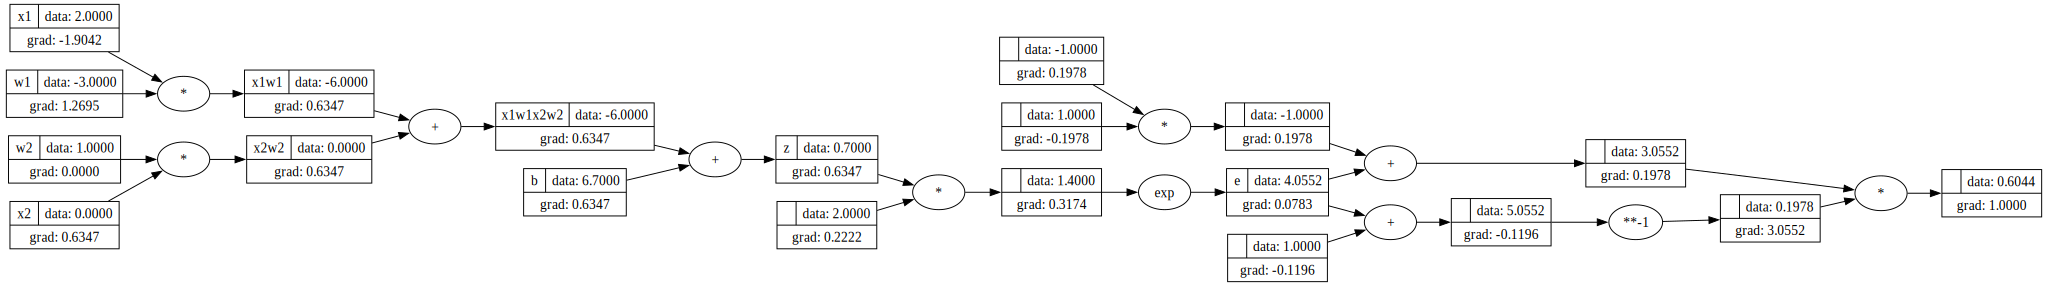

In [76]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

b = Value(6.7, label='b')

x1w1 = x1 * w1; x1w1._label = 'x1w1'
x2w2 = x2 * w2; x2w2._label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2._label = 'x1w1x2w2'
z = x1w1x2w2 + b; z._label = 'z'

e = (2 * z).exp(); e._label = 'e'
o = (e - 1) / (e + 1)

o.backward()

draw_graph(o)

In [83]:
import torch

x1 = torch.DoubleTensor([2.0]); x1.requires_grad_(True)
x2 = torch.DoubleTensor([0.0]); x2.requires_grad_(True)
w1 = torch.DoubleTensor([-3.0]); w1.requires_grad_(True)
w2 = torch.DoubleTensor([1.0]); w2.requires_grad_(True)
b = torch.DoubleTensor([6.7])

z = x1 * w1 + x2 * w2 + b
print(z)
o = torch.tanh(z)
print(o.data.item())

o.backward()

print("x1", x1.grad.data.item())
print("x2", x2.grad.data.item())
print("w1", w1.grad.data.item())
print("w2", w2.grad.data.item())


tensor([0.7000], dtype=torch.float64, grad_fn=<AddBackward0>)
0.6043677771171636
x1 -1.9042187699473754
x2 0.6347395899824585
w1 1.269479179964917
w2 0.0


# Building a NN

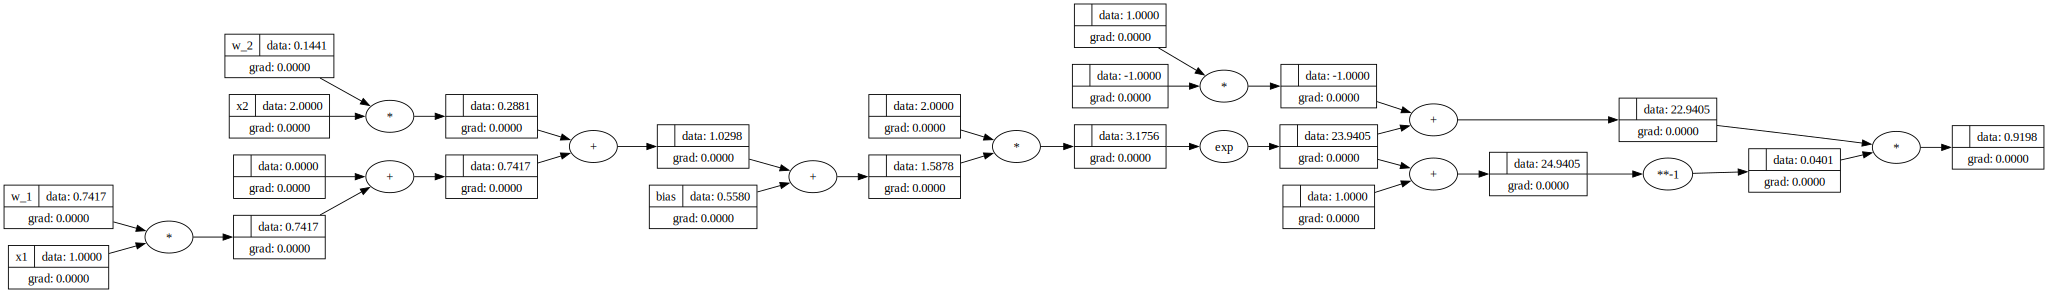

In [132]:
import random

class Neuron:

    def __init__(self, input_size):
        self.w = [Value(random.uniform(-1, 1), label=f"w_{i+1}") for i in range(input_size)]
        self.b = Value(random.uniform(-1, 1), label='bias')

    def __call__(self, x):
        output = sum(xi * wi for xi, wi in zip(x, self.w)) + self.b
        e = (2 * output).exp()
        return (e - 1) / (e + 1)
    

nr = Neuron(2)
x = [Value(1.0, label='x1'), Value(2.0, label='x2')]

output = nr(x)

draw_graph(output)

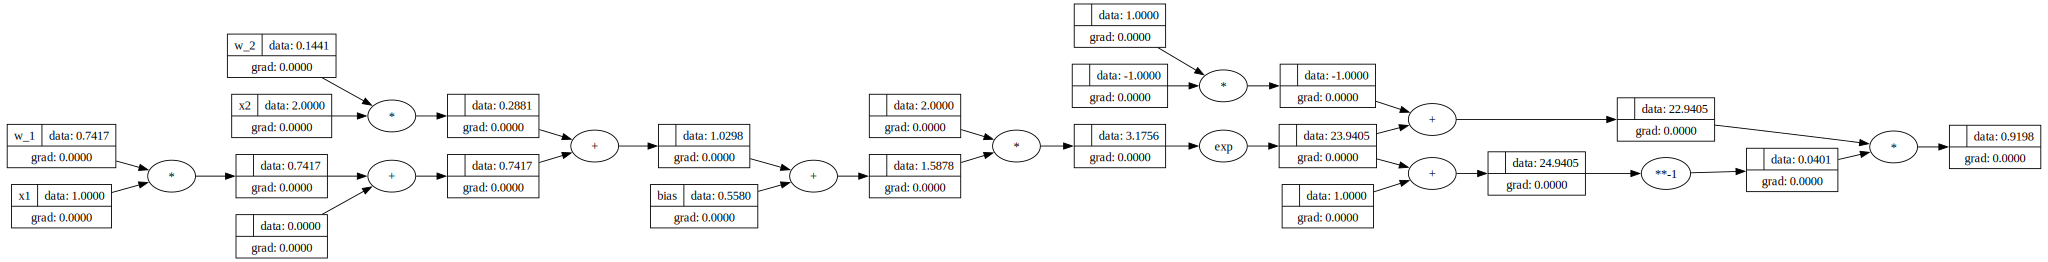

In [133]:
output = nr(x)

draw_graph(output)

In [134]:
print(nr(x))
print(nr(x))

Value(data=0.9198093014096242, _op=*, label=)
Value(data=0.9198093014096242, _op=*, label=)


In [140]:
class Layer:

    def __init__(self, input_size, output_size) -> None:
        self.neurons = [Neuron(input_size) for _ in range(output_size)]

    def __call__(self, x):
        outputs = [nr(x) for nr in self.neurons]
        return outputs[0] if len(outputs) == 1 else outputs
    


In [141]:
x = [2.0, 3.0]
n = Layer(2, 3)
print(n(x))
print(n(x))


[Value(data=-0.7762950007318533, _op=*, label=), Value(data=-0.3346659706645829, _op=*, label=), Value(data=-0.9782981836798601, _op=*, label=)]
[Value(data=-0.7762950007318533, _op=*, label=), Value(data=-0.3346659706645829, _op=*, label=), Value(data=-0.9782981836798601, _op=*, label=)]


In [142]:
class MLP:

    def __init__(self, input_size, layer_sizes) -> None:
        layer_dims = [input_size] + layer_sizes
        self.layers = [Layer(layer_dims[i], layer_dims[i + 1]) for i in range(len(layer_sizes))]

    def __call__(self, x):
        output = x
        for layer in self.layers:
            output = layer(output)
        return output

In [146]:
x = [2.0, 3.0, -1.0]
mlp = MLP(3, [4, 4, 1])
mlp(x)

Value(data=-0.3058730842047438, _op=*, label=)

In [147]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]

ys = [1.0, -1.0, -1.0, 1.0]
ypred = [mlp(x) for x in xs]
ypred

[Value(data=-0.3058730842047438, _op=*, label=),
 Value(data=-0.7162864463358836, _op=*, label=),
 Value(data=-0.6173150712674774, _op=*, label=),
 Value(data=-0.5177759533100967, _op=*, label=)]

In [145]:
mlp(xs[0])

Value(data=-0.15890719041206133, _op=*, label=)

In [148]:
loss = [(a - b) ** 2 for a, b in zip(ypred, ys)]
loss

[Value(data=1.7053045120504096, _op=**2, label=),
 Value(data=0.08049338053272148, _op=**2, label=),
 Value(data=0.14644775467901588, _op=**2, label=),
 Value(data=2.303643844446373, _op=**2, label=)]

In [149]:
total_loss = sum(loss) / 4
total_loss

Value(data=1.0589723729271299, _op=*, label=)

In [150]:
total_loss.backward()

Value(data=1.0589723729271299, _op=*, label=) _backward
Value(data=4.2358894917085195, _op=+, label=) _backward
Value(data=2.303643844446373, _op=**2, label=) _backward
Value(data=-1.5177759533100967, _op=+, label=) _backward
Value(data=-0.5177759533100967, _op=*, label=) _backward
Value(data=-0.6822824570133508, _op=+, label=) _backward
Value(data=-1, _op=*, label=) _backward
Value(data=1, _op=, label=) _backward
Value(data=-1, _op=, label=) _backward
Value(data=0.7588879766550484, _op=**-1, label=) _backward
Value(data=1.3177175429866492, _op=+, label=) _backward
Value(data=0.3177175429866492, _op=exp, label=) _backward
Value(data=-1.1465925205133507, _op=*, label=) _backward
Value(data=-0.5732962602566753, _op=+, label=) _backward
Value(data=0.23415442549821625, _op=+, label=) _backward
Value(data=0.04081906770268534, _op=+, label=) _backward
Value(data=0.3991834019409892, _op=+, label=) _backward
Value(data=0.16848206888238632, _op=+, label=) _backward
Value(data=0.1684820688823863

In [151]:
lr = 0.01
for layer in mlp.layers:
    for nr in layer.neurons:
        for wi in nr.w:
            wi.data -= lr * wi._grad
        nr.b.data -= lr * nr.b._grad

In [152]:
ypred = [mlp(x) for x in xs]
ypred

[Value(data=-0.20386536734608005, _op=*, label=),
 Value(data=-0.7011374618727705, _op=*, label=),
 Value(data=-0.5936348220817742, _op=*, label=),
 Value(data=-0.47349676504057864, _op=*, label=)]

In [153]:
loss = [(a - b) ** 2 for a, b in zip(ypred, ys)]
total_loss = sum(loss) / 4
total_loss


Value(data=0.9687340034501808, _op=*, label=)

In [184]:
import random

class Neuron:

    def __init__(self, input_size):
        self.w = [Value(random.uniform(-1, 1), label=f"w_{i+1}") for i in range(input_size)]
        self.b = Value(random.uniform(-1, 1), label='bias')

    def __call__(self, x):
        output = sum(xi * wi for xi, wi in zip(x, self.w)) + self.b
        e = (2 * output).exp()
        return (e - 1) / (e + 1)
    
    def parameters(self):
        return self.w + [self.b]
    

class Layer:

    def __init__(self, input_size, output_size) -> None:
        self.neurons = [Neuron(input_size) for _ in range(output_size)]

    def __call__(self, x):
        outputs = [nr(x) for nr in self.neurons]
        return outputs[0] if len(outputs) == 1 else outputs
    
    def parameters(self):
        param_list = [nr.parameters() for nr in self.neurons]
        params = param_list[0]
        for pr in param_list[1:]:
            params = params + pr
        return params
    
    
class MLP:

    def __init__(self, input_size, layer_sizes) -> None:
        layer_dims = [input_size] + layer_sizes
        self.layers = [Layer(layer_dims[i], layer_dims[i + 1]) for i in range(len(layer_sizes))]

    def __call__(self, x):
        output = x
        for layer in self.layers:
            output = layer(output)
        return output
    
    def parameters(self):
        param_list = [layer.parameters() for layer in self.layers]
        params = param_list[0]
        for pr in param_list[1:]:
            params = params + pr
        return params


In [185]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]

ys = [1.0, -1.0, -1.0, 1.0]

mlp = MLP(3, [4, 4, 1])
ypred = [mlp(x) for x in xs]
ypred

[Value(data=0.8973420535282822, _op=*, label=),
 Value(data=-0.5180951874226247, _op=*, label=),
 Value(data=0.8222345018993293, _op=*, label=),
 Value(data=0.720194172734887, _op=*, label=)]

In [186]:
def rme_loss(pred, target):
    return sum(((x - y)**2 for x, y in zip(pred, target))) / len(target)

total_loss = rme_loss(ypred, ys)
print(total_loss)
total_loss.backward()

Value(data=0.9104001958107092, _op=*, label=)


In [187]:
lr = 0.01
for pr in mlp.parameters():
    pr.data -= pr._grad * lr

In [188]:
ypred = [mlp(x) for x in xs]

In [189]:
total_loss = rme_loss(ypred, ys)
print(total_loss)


Value(data=0.892835762191172, _op=*, label=)


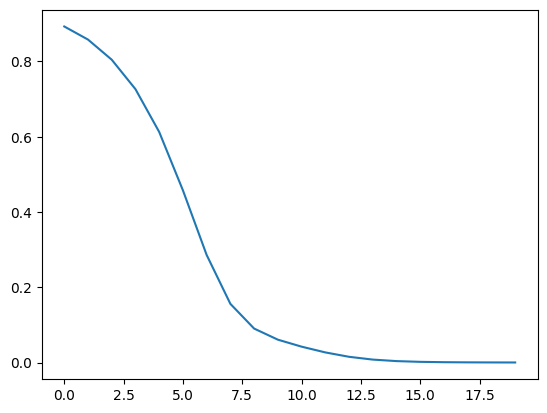

In [190]:
losses = []
def train(n_iter):
    for _ in range(n_iter):
        ypred = [mlp(x) for x in xs]
        loss = rme_loss(ypred, ys)
        loss.backward()

        for pr in mlp.parameters():
            pr.data -= pr._grad * lr
        losses.append(loss.data)

train(20)

plt.plot(losses)